A character level bigram language model doesnt work very good. The results it gives are pretty bad. Also using the same logic doesnt work as the size of matrix increases exponentially as it was 27*27 and taking another character into context makes it 27*27*27. So due to ths we have to make use of different approach which is MLP(multi layer perceptron). A perceptron is a simplest neural networn just a neuron which gives out a binary output. Lets start!!

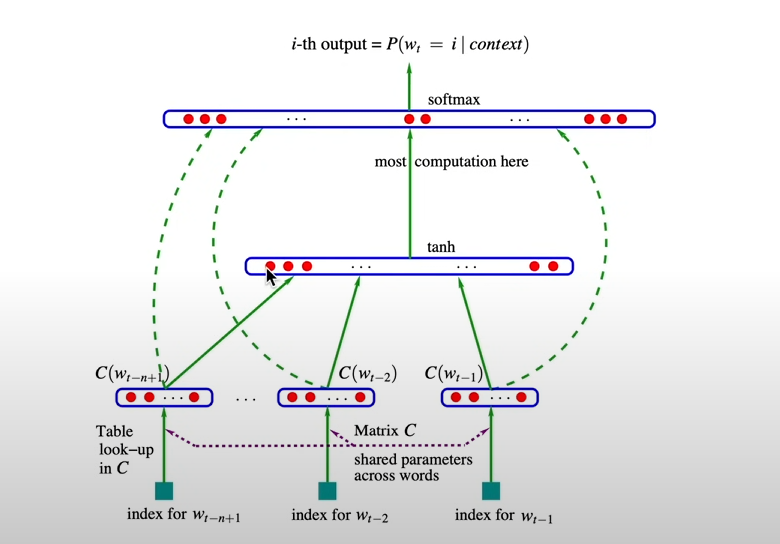

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-02-23 11:33:15--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.3’

names.txt.3         100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2025-02-23 11:33:15 (46.9 MB/s) - ‘names.txt.3’ saved [228145/228145]



In [ ]:
import torch
import torch.nn.functional as F
import matplotlib as plt
%matplotlib inline

In [ ]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Taking random embeddings for each of the character for example a is [0.517,-0.512] so now instead of writing integer of that character it is replaced by its embedding which helps in getting more information.

now building first activation layer



100 neurons and 6 inputs which is 2*3

now the final layer
input here is 100 from 100 neurons from previous layer and output is a possibility from 27 characters.



In [ ]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad=True

In [ ]:
lre= torch.linspace(-3,0,1000)
lrs=10**lre

In [ ]:
lri=[]
lossi=[]
stepi=[]

In [ ]:


for i in range(50000):
  ix = torch.randint(0,Xtr.shape[0],(32,))

  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,30)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Ytr[ix])
  for p in parameters:
    p.grad=None
  #print(loss.item())
  loss.backward()


  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss.item())


1.9746242761611938


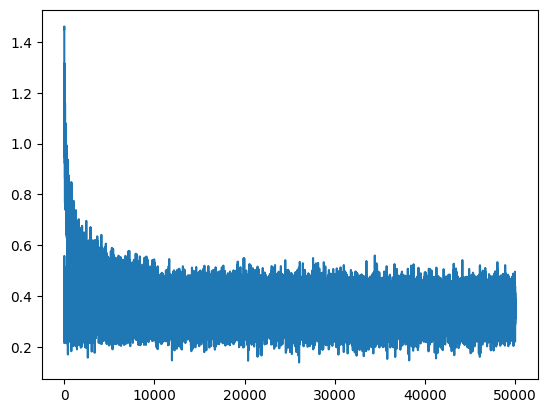

In [ ]:
import matplotlib.pyplot as plt

plt.plot(stepi,lossi)

In [ ]:

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1579, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1856, grad_fn=<NllLossBackward0>)

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryah.
remmaniendrari.
azeemdieliigh.
porea.
eden.
sananar.
kayzion.
kalin.
shubergihianest.
jaireth.
konn.
pacon.
bren.
dariyah.
fael.
yuma.
